In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import chi2
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import string
import io
import re
pd.options.display.max_colwidth=500
df=pd.read_csv("CBK2020transformed.csv")
df=df.drop(df.columns[[0]], axis = 1)
df = df.sample(frac=1).reset_index(drop=False)
df=df.drop(df.columns[[0]], axis = 1)
print(len(pd.DataFrame(df)))
df.head()

5383


,Device_Problems,Event_description,Narrative,Event_description_Narrative
0,Mechanical_Problems,"Complainant alleged that during a routine shift check by a clinician, the device displayed a ""compressor failure -1001"" error message. Complainant indicated that there was no patient involvement in the reported malfunction.",The customer was contacted for return of the suspect product. The product has not been returned to zoll for evaluation.,"Complainant alleged that during a routine shift check by a clinician, the device displayed a ""compressor failure -1001"" error message. Complainant indicated that there was no patient involvement in the reported malfunction.The customer was contacted for return of the suspect product. The product has not been returned to zoll for evaluation."
1,Mechanical_Problems,"The customer reported that while the vela ventilator was running on a patient low ve (low minute ventilation), transducer fault and high rate alarm occurred. The patient was transferred to another ventilator. The customer there is no patient harm associated with this reported event.","At this time, the suspect device has not been returned for evaluation. Therefore, root cause has not been determined yet. Vyaire medical will submit a supplemental report in accordance with 21 cfr section 803. 56 if additional information becomes available.","The customer reported that while the vela ventilator was running on a patient low ve (low minute ventilation), transducer fault and high rate alarm occurred. The patient was transferred to another ventilator. The customer there is no patient harm associated with this reported event.At this time, the suspect device has not been returned for evaluation. Therefore, root cause has not been determined yet. Vyaire medical will submit a supplemental report in accordance with 21 cfr section 803. 56 ..."
2,Calibration_Problems,"The manufacturer received information alleging a ventilators oxygen percentage could not be increased from 21%. The device was not in patient use. The device has not yet been returned the manufacturer for evaluation. At this time, we are unable to confirm the alleged malfunction. A follow-up report will be submitted when the manufacturers investigation is complete.","It was initially reported, the manufacturer received information alleging a ventilators oxygen percentage could not be increased from 21%. The device was not in patient use. Repeated attempts for additional information or to have the device returned for evaluation and investigation were unsuccessful. The manufacturer believes they will be unable to gather additional information. The manufacturer is submitting a final report at this time. If pertinent information becomes available to the manu...","The manufacturer received information alleging a ventilators oxygen percentage could not be increased from 21%. The device was not in patient use. The device has not yet been returned the manufacturer for evaluation. At this time, we are unable to confirm the alleged malfunction. A follow-up report will be submitted when the manufacturers investigation is complete.It was initially reported, the manufacturer received information alleging a ventilators oxygen percentage could not be increased ..."
3,Mechanical_Problems,"The customer reported that the vela ventilator does not work properly and giving xdcr error. At this time, there is no information regarding patient involvement associated with the reported event.","Vyaire file identification: (b)(4). At this time, the suspect device has not been returned for evaluation. Therefore, root cause has not been determined yet.","The customer reported that the vela ventilator does not work properly and giving xdcr error. At this time, there is no information regarding patient involvement associated with the reported event.Vyaire file identification: (b)(4). At this time, the suspect device has not been returned for evaluation. Therefore, root cause has not been determined yet."
4,Mech

In [2]:
Names_red_DP_list=['Calibration_Problems','Software_Problems','Circuit_failure','Power_Problems','Mechanical_Problems']
Names_DP_list=['Calibration','Software','Circuit','Power','Mechanical']
for i in range(0, len(Names_red_DP_list)):
    df.Device_Problems= df.Device_Problems.replace(Names_red_DP_list[i],Names_DP_list[i])
print('Number_Of_Device_Problems =',len(pd.DataFrame(df.Device_Problems.value_counts())))
(pd.DataFrame(df.Device_Problems.value_counts()))

Number_Of_Device_Problems = 5


,Device_Problems
Mechanical,1937
Circuit,1566
Calibration,1186
Power,612
Software,82


In [3]:
pd.DataFrame(df.Device_Problems.value_counts())

,Device_Problems
Mechanical,1937
Circuit,1566
Calibration,1186
Power,612
Software,82


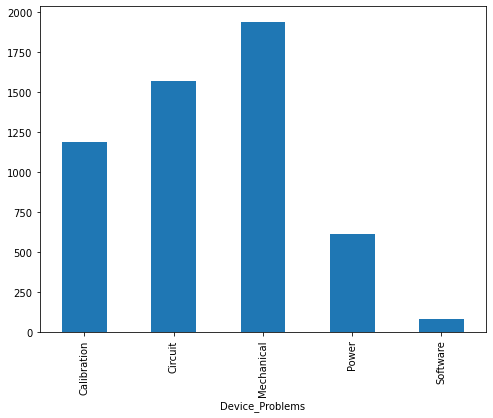

In [4]:
fig = plt.figure(figsize=(8,6))
df.groupby('Device_Problems').Event_description_Narrative.count().plot.bar(ylim=0)
plt.show()

In [5]:
col = ['Device_Problems', 'Event_description_Narrative']
df= df[col]
df= df[pd.notnull(df['Event_description_Narrative'])]
#result = result[pd.notnull(result['Event_description'])]
df.columns = ['Device_Problems', 'Event_description_Narrative']
df['category_id'] =df['Device_Problems'].factorize()[0]
category_id_df= df[['Device_Problems', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category= dict(category_id_df[['category_id', 'Device_Problems']].values)
print(len(df))
df.sample(n=3)

5383


,Device_Problems,Event_description_Narrative,category_id
3151,Software,"The customer reported bellavista 1000 known black screen issue with g6 units prior patient use. Furthermore, there was no patient involvement associated with the event.Vyaire file identification: (b)(4). Any additional information received from the customer will be included in a follow-up report. At this time, the suspect device has not been return for investigation however, this is a known issue from g6 units. Therefore, technical support traced the issue to the epc component and initiated ...",4
4861,Circuit,The customer contacted technical support (ts) stating that the unit had an error code message of maximum system resets exceeded. The customer reported there was no patient involvement.Date of event: (b)(6) 2020. Date of report: 19oct2020.,2
1503,Circuit,"The customer reported that the screen goes black when the avea ventilator is booted up. At this time, there is no information regarding patient involvement associated with the reported event.(b)(4). At this time, the suspect device has not been returned for evaluation. Therefore, root cause has not been determined yet. However, the technical support suggested replacing the power supply aside from the customers requested replacement parts. Vyaire medical will submit a supplemental report in a...",2


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2',
                        encoding='latin-1', ngram_range=(1, 2), 
                        stop_words='english')
features = tfidf.fit_transform(df["Event_description_Narrative"]).toarray()
labels = df.category_id
features.shape

(5383, 5145)

In [7]:
N = 10
for Device_Problems, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Device_Problems))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Calibration':
  . Most correlated unigrams:
. pneumatic
. internal
. failed
. non
. block
. test
. nrv
. resmed
. complete
. self
  . Most correlated bigrams:
. complaint pneumatic
. pneumatic block
. return valve
. non return
. device failed
. self test
. test patient
. internal self
. complete internal
. failed complete
# 'Circuit':
  . Most correlated unigrams:
. screen
. self
. manufacturers
. complaints
. activities
. unanticipated
. 2020
. getinge
. display
. date
  . Most correlated bigrams:
. unanticipated repair
. repair activities
. submitted complaints
. date report
. event 2020
. failed complete
. complete internal
. internal self
. device failed
. date event
# 'Mechanical':
  . Most correlated unigrams:
. medical
. information
. transducer
. fault
. suspect
. associated
. additional
. vela
. resmed
. vyaire
  . Most correlated bigrams:
. root cause
. involvement associated
. transducer fault
. cause determined
. evaluation root
. associated reported
. suspect device
. a

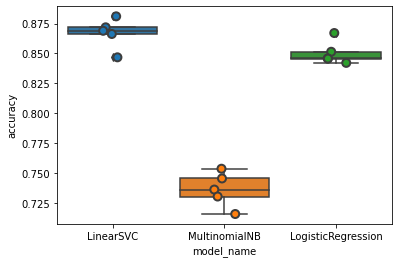

In [8]:
models = [
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [9]:
pd.DataFrame(cv_df.groupby('model_name').accuracy.mean())

,accuracy
model_name,
LinearSVC,0.866992
LogisticRegression,0.850457
MultinomialNB,0.736394


(4306, 5145) (1077, 5145) (4306,) (1077,)


Text(0.5, 69.0, 'Predicted')

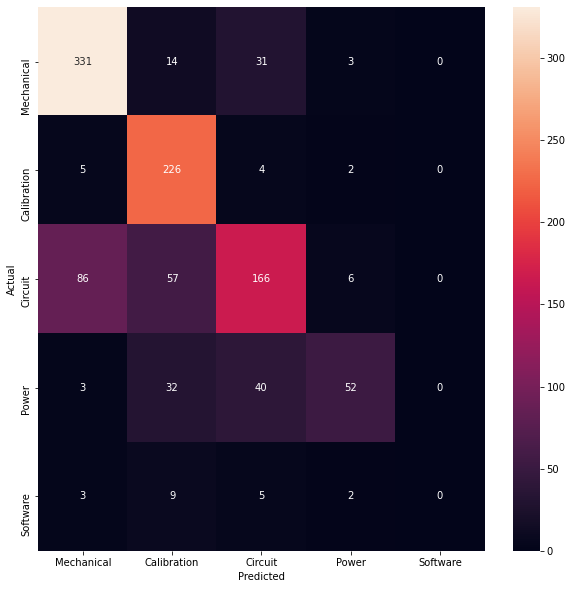

In [10]:
model = MultinomialNB()
X_train, X_test, y_train, y_test, indices_train, indices_test =train_test_split(features, 
                                            labels,df.index ,
                                            test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
#rename=['Circuit','Mechanical','Calibration','Power','Software']
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Device_Problems.values, yticklabels=category_id_df.Device_Problems.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [11]:
from sklearn.metrics import accuracy_score,classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.7195914577530177
              precision    recall  f1-score   support

           0       0.77      0.87      0.82       379
           1       0.67      0.95      0.79       237
           2       0.67      0.53      0.59       315
           3       0.80      0.41      0.54       127
           4       0.00      0.00      0.00        19

    accuracy                           0.72      1077
   macro avg       0.58      0.55      0.55      1077
weighted avg       0.71      0.72      0.70      1077



C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(4306, 5145) (1077, 5145) (4306,) (1077,)


Text(0.5, 69.0, 'Predicted')

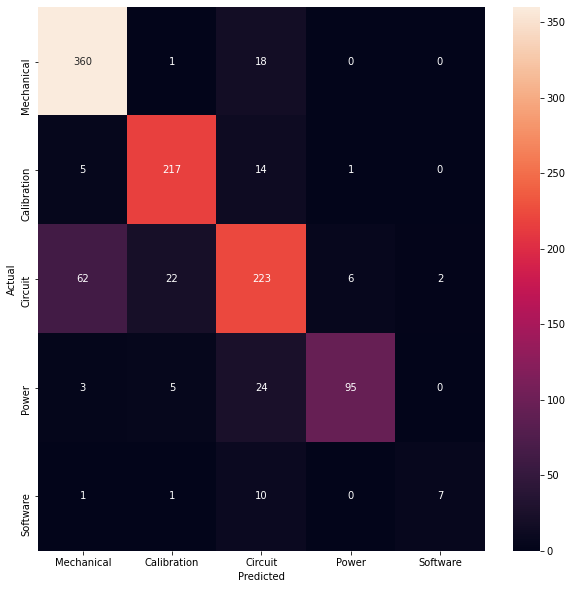

In [12]:
model = LogisticRegression(random_state=0)
X_train, X_test, y_train, y_test, indices_train, indices_test =train_test_split(features, 
                                            labels,df.index ,
                                            test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
#rename=['Circuit','Mechanical','Calibration','Power','Software']
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Device_Problems.values, yticklabels=category_id_df.Device_Problems.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [13]:
from sklearn.metrics import accuracy_score,classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.8375116063138347
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       379
           1       0.88      0.92      0.90       237
           2       0.77      0.71      0.74       315
           3       0.93      0.75      0.83       127
           4       0.78      0.37      0.50        19

    accuracy                           0.84      1077
   macro avg       0.84      0.74      0.77      1077
weighted avg       0.84      0.84      0.83      1077



(4306, 5145) (1077, 5145) (4306,) (1077,)


Text(0.5, 69.0, 'Predicted')

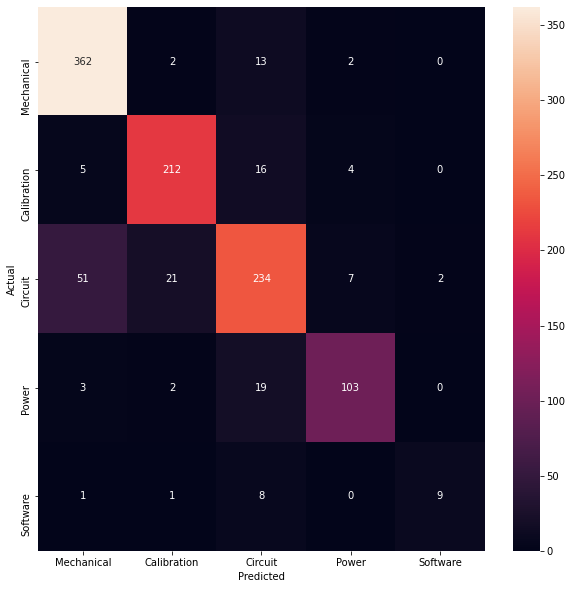

In [14]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test =train_test_split(features, 
                                            labels,df.index ,
                                            test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
#rename=['Circuit','Mechanical','Calibration','Power','Software']
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Device_Problems.values, yticklabels=category_id_df.Device_Problems.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

(4306, 5145) (1077, 5145) (4306,) (1077,)
[1]


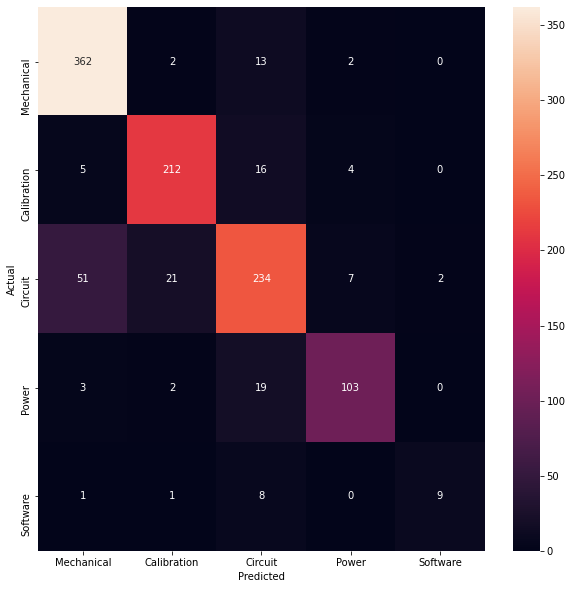

In [15]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test =train_test_split(features, 
                                            labels,df.index ,
                                            test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
#rename=['Circuit','Power','Calibration','Mechanical','Software']
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Device_Problems.values, yticklabels=category_id_df.Device_Problems.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
print(model.predict(tfidf.transform(["It was reported to resmed that an astral device failed to complete its \
internal self-test. There was no patient harm or serious injury reported as a result of this incident.The device was \
returned to resmed and an evaluation confirmed the complaint. The non-return valve (nrv) assembly was replaced to \
address this issue. The device was serviced and fully tested before it was returned to the customer. Resmeds risk\
analysis for this failure mode concludes that the risk is acceptable. (b)(4)."])))

In [16]:
from sklearn.metrics import accuracy_score,classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.8542246982358404
              precision    recall  f1-score   support

           0       0.86      0.96      0.90       379
           1       0.89      0.89      0.89       237
           2       0.81      0.74      0.77       315
           3       0.89      0.81      0.85       127
           4       0.82      0.47      0.60        19

    accuracy                           0.85      1077
   macro avg       0.85      0.78      0.80      1077
weighted avg       0.85      0.85      0.85      1077

